In [1]:
#Load Importance sampling functions
import sys
sys.path.append('../src')

In [16]:
import datetime, zarr, dask, rasterio as rio, rioxarray as rxr, pandas as pd, rasterstats, tqdm, pathlib, geopandas as gpd, matplotlib.pyplot as plt
from scipy.stats import uniform, norm, multivariate_normal, truncnorm
import plotnine as pn
import os
import subprocess
import importlib
import pyDOE2
from tqdm import tqdm
import numpy as np

from transpose import *
from utils import *
from evaluation import *

<h5>Download Data</h5>

In [ ]:
#Download data from AWS
#1. In terminal - 
    # curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    # unzip awscliv2.zip
    # sudo ./aws/install
#3. In terminal inside docker type - aws configure
#4. Add key provided by admin and set region to us-west-2 and output format to json

#Duwamish S3 URL for tif files 
s3_url = "s3://importance-sampling-sst/Duwamish/"
local_dir = "/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish"
os.makedirs(local_dir)
subprocess.run(["aws","s3","cp",s3_url,local_dir,"--recursive"], check = True)

In [4]:
#Locate data
path_sp_watershed = "/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/geojson/duwamish.geojson"
path_sp_domain = "/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/geojson/duwamish-transpo-area-v01.geojson"

path_storm = pathlib.Path('/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/catalog')
df_storms = pd.read_pickle(path_storm/'catalog.pkl')

In [5]:
#Load shapefiles and match projection with rasters
sp_watershed = gpd.read_file(path_sp_watershed)
sp_watershed = match_crs_to_raster(sp_watershed, df_storms['path'].iloc[0])

sp_domain = gpd.read_file(path_sp_domain)
sp_domain = match_crs_to_raster(sp_domain, df_storms['path'].iloc[0])

Reprojecting polygon from EPSG:4326 to EPSG:5070...
Reprojecting polygon from EPSG:4326 to EPSG:5070...


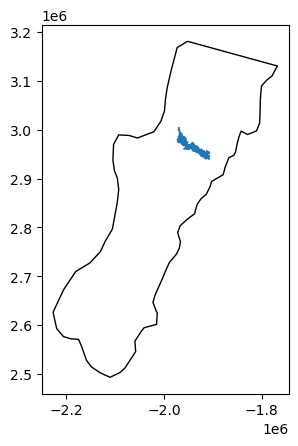

In [6]:
sp_watershed.plot()
sp_domain.plot(ax=plt.gca(),facecolor="none")
plt.show()

In [7]:
v_watershed_stats = get_sp_stats(sp_watershed)
v_domain_stats = get_sp_stats(sp_domain)
print(v_watershed_stats, v_domain_stats)

minx       -1.974568e+06
miny        2.938089e+06
maxx       -1.905108e+06
maxy        3.005395e+06
x          -1.942311e+06
y           2.965859e+06
range_x     6.946011e+04
range_y     6.730658e+04
area_km2    2.732960e+03
Name: 0, dtype: float64 minx       -2.226803e+06
miny        2.493512e+06
maxx       -1.768135e+06
maxy        3.180672e+06
x          -2.008039e+06
y           2.857018e+06
range_x     4.586682e+05
range_y     6.871599e+05
area_km2    2.486725e+05
Name: 0, dtype: float64


In [8]:
dist_x = truncnorm(**truncnorm_params(v_watershed_stats.x, v_watershed_stats.range_x*1, v_domain_stats.minx, v_domain_stats.maxx))
dist_y = truncnorm(**truncnorm_params(v_watershed_stats.y, v_watershed_stats.range_y*1, v_domain_stats.miny, v_domain_stats.maxy))

In [25]:
n_sim_mc_0 = 10000
n_sim_is_1 = 1000
df_storm_sample_mc_0 = sample_storms(df_storms, v_domain_stats, dist_x=None, dist_y=None, num_simulations=n_sim_mc_0)
df_storm_sample_mc_1 = sample_storms(df_storms, v_domain_stats, dist_x=None, dist_y=None, num_simulations=n_sim_is_1)
df_storm_sample_is_1 = sample_storms(df_storms, v_domain_stats, dist_x, dist_y, num_simulations=n_sim_is_1)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 5385.67it/s]


In [26]:
df_depths_mc_0 = compute_depths(df_storm_sample_mc_0, sp_watershed)
df_depths_mc_1 = compute_depths(df_storm_sample_mc_1, sp_watershed)
df_depths_is_1 = compute_depths(df_storm_sample_is_1, sp_watershed)

100%|██████████| 1000/1000 [00:21<00:00, 47.50it/s]


In [32]:
print_sim_stats(df_depths_mc_0)
print_sim_stats(df_depths_mc_1)
print_sim_stats(df_depths_is_1)

Intersected: 8747 out of 10000 (87.47%)
Total Weights: Total  1.00, Intersected: 0.87
Depth: 21.09 ± 0.35
Depth Estimate: 21.09 ± 0.35
Intersected: 870 out of 1000 (87.00%)
Total Weights: Total  1.00, Intersected: 0.87
Depth: 22.26 ± 1.15
Depth Estimate: 22.26 ± 1.15
Intersected: 957 out of 1000 (95.70%)
Total Weights: Total  1.00, Intersected: 0.80
Depth: 28.42 ± 1.19
Depth Estimate: 13.52 ± 1.63


In [33]:
df_freq_curve_mc_0 = get_df_freq_curve(df_depths_mc_0.depth, df_depths_mc_0.prob)
df_freq_curve_mc_1 = get_df_freq_curve(df_depths_mc_1.depth, df_depths_mc_1.prob)
df_freq_curve_is_1 = get_df_freq_curve(df_depths_is_1.depth, df_depths_is_1.prob)

In [ ]:
df_freq_curve_mc_0['prob_exceed2'] = 1 - np.exp(-10*df_freq_curve_mc_0.prob_exceed)
df_freq_curve_mc_0['rp'] = 1/df_freq_curve_mc_0['prob_exceed2']

df_freq_curve_mc_1['prob_exceed2'] = 1 - np.exp(-10*df_freq_curve_mc_1.prob_exceed)
df_freq_curve_is_1['prob_exceed2'] = 1 - np.exp(-10*df_freq_curve_is_1.prob_exceed)

In [35]:
df_freq_curve_mc_0['rp'] = 1/df_freq_curve_mc_0['prob_exceed2']
df_freq_curve_mc_1['rp'] = 1/df_freq_curve_mc_1['prob_exceed2']
df_freq_curve_is_1['rp'] = 1/df_freq_curve_is_1['prob_exceed2']

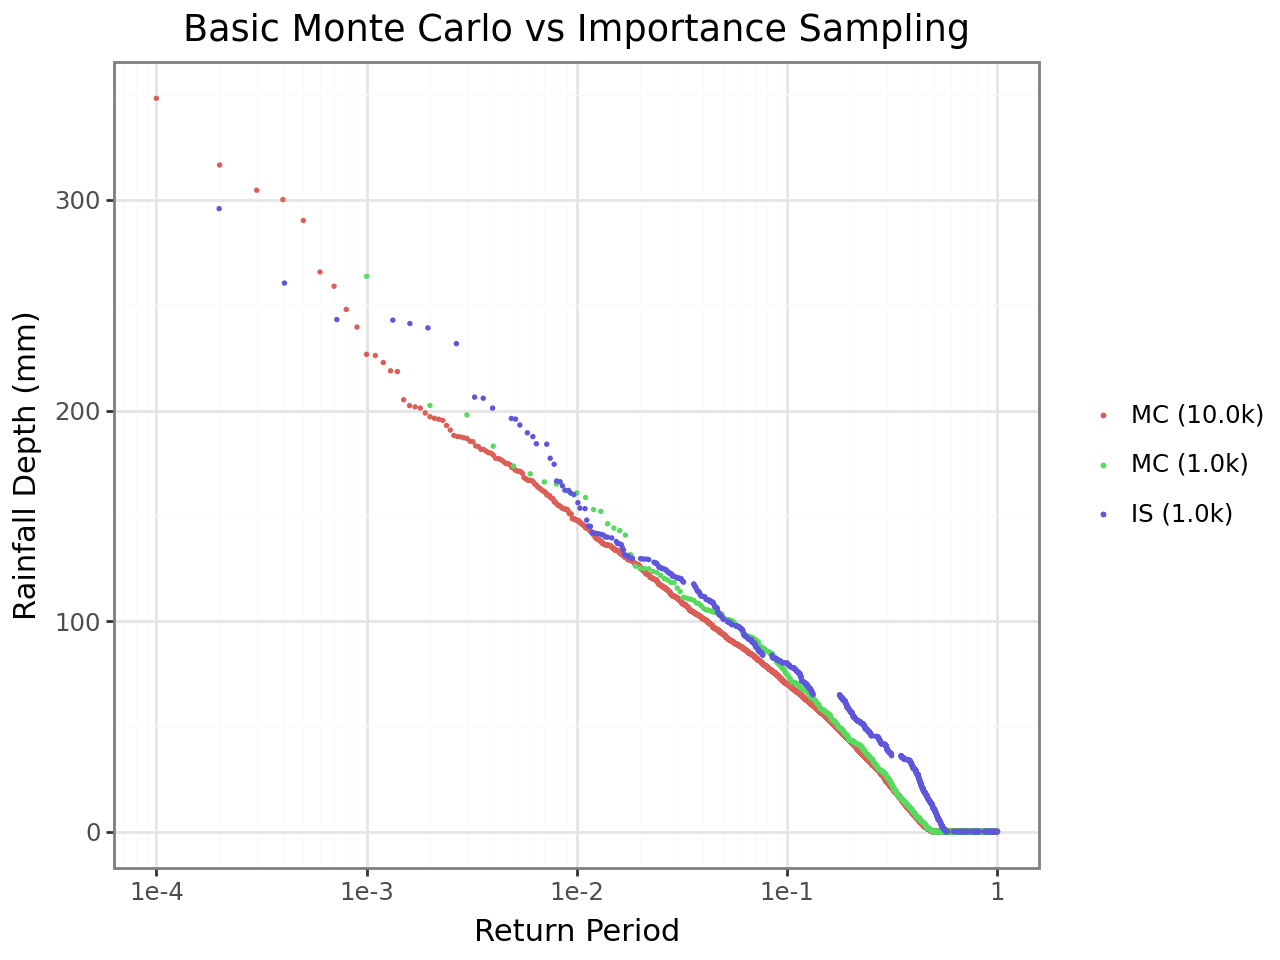

In [36]:
(pn.ggplot(mapping=pn.aes(x='prob_exceed', y='depth'))
        + pn.geom_point(data=df_freq_curve_mc_0, mapping=pn.aes(color=f'"MC ({n_sim_mc_0/1000}k)"'), size=0.1)
        + pn.geom_point(data=df_freq_curve_mc_1, mapping=pn.aes(color=f'"MC ({n_sim_is_1/1000}k)"'), size=0.1)
        + pn.geom_point(data=df_freq_curve_is_1, mapping=pn.aes(color=f'"IS ({n_sim_is_1/1000}k)"'), size=0.1)
        + pn.scale_x_log10()
        + pn.labs(
            x = 'Return Period',
            y = 'Rainfall Depth (mm)',
            title = 'Basic Monte Carlo vs Importance Sampling'
        )
        + pn.theme_bw()
        + pn.theme(
            title = pn.element_text(hjust = 0.5),
            # legend_position = 'bottom',
            legend_title = pn.element_blank(),
            legend_key = pn.element_blank(),
            axis_title_y = pn.element_text(ha = 'left'),
        )
    )

In [37]:
df_freq_curve_is_1['rp'].max()

np.float64(503.1028359811769)

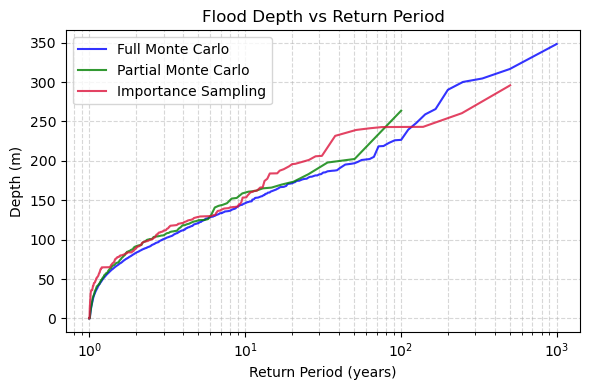

In [38]:
# Plot Return Period vs Depth with better colors
plt.figure(figsize=(6, 4))

plt.semilogx(df_freq_curve_mc_0['rp'], df_freq_curve_mc_0['depth'],
             linestyle='-', color='blue', alpha=0.8, label='Full Monte Carlo')

plt.semilogx(df_freq_curve_mc_1['rp'], df_freq_curve_mc_1['depth'],
             linestyle='-', color='green', alpha=0.8, label='Partial Monte Carlo')

plt.semilogx(df_freq_curve_is_1['rp'], df_freq_curve_is_1['depth'],
             linestyle='-', color='crimson', alpha=0.8, label='Importance Sampling')

plt.xlabel('Return Period (years)')
plt.ylabel('Depth (m)')
plt.title('Flood Depth vs Return Period')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

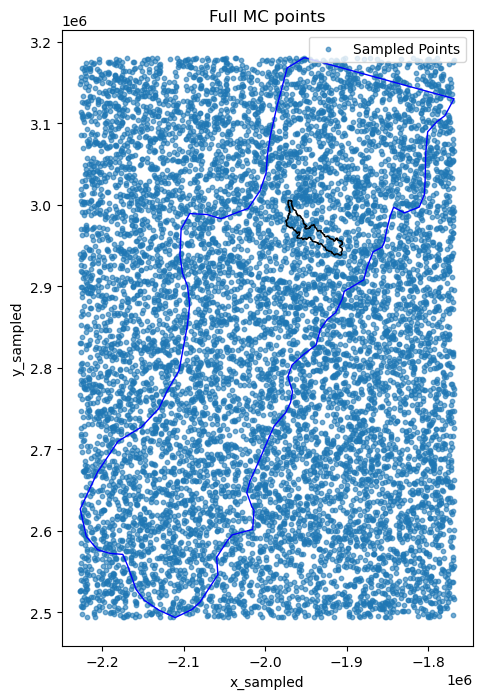

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))
df_depths_mc_0.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("Full MC points")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()

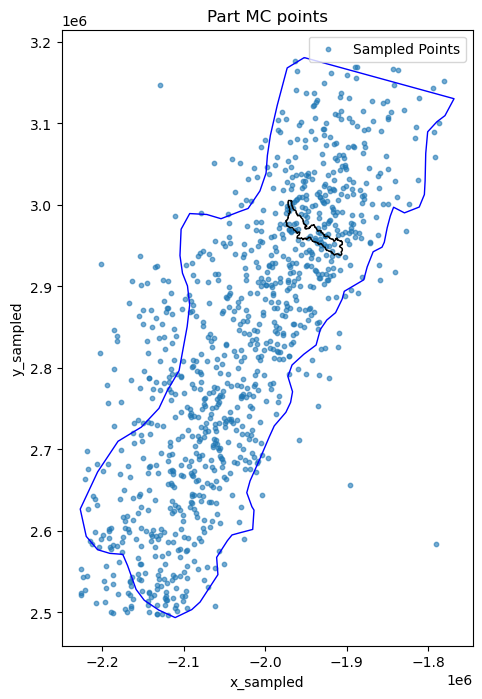

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
df_depths_mc_1.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("Part MC points")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()

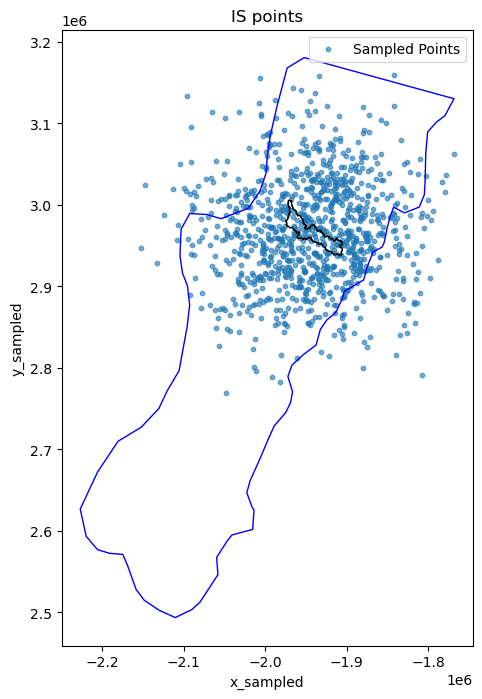

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))
df_depths_is_1.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("IS points")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()